In [1]:
import nltk

import sklearn
from sklearn import linear_model
from sklearn import metrics

import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import *
import pandas as pd

import re
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from nltk import word_tokenize
import torch.nn as nn
import torch
from sklearn.metrics import roc_auc_score
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import torch.optim as optim
import time
import torch
torch.cuda.empty_cache()

In [2]:
from google.colab import files
uploaded = files.upload()
# verify GPU availability
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Saving training (1).xlsx to training (1).xlsx
Found GPU at: /device:GPU:0


In [2]:

# install
!pip install pytorch_pretrained_bert 
# BERT imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [3]:

stops = set()
def clean_text(string):
    text = string.lower().split()
    text = " ".join(text)
    text = re.sub(r"http(\S)+", '', text)
    text = re.sub(r"www(\S)+", '', text)
    text = re.sub(r"&", ' and ', text)
    #text = re.sub(r"[^0-9a-z #+_]", '', text) #todo maybe should not add this line it will dramatically decrease the auc score
    text = re.sub('[0-9]+', '.', text)
    text = text.split("(reuters) - ")[-1].split("reuters")[-1]
    text = text.split()
    text = [w for w in text if "ä" not in w]
    text = [w for w in text if w not in stops]
    text = " ".join(text)

    return text


def extract_data_from_file(filename, index=None):
    data = pd.read_excel(filename)
    if index == None:

        string_list = [str(clean_text(news)) for news in
                       data["tweet"]]  # todo it seems that original file contains float
        output = [1 if element == "real" or element == 0 else 0 for element in data["label"]]
    else:
        string_list = [str(clean_text(news)) for news in
                       data["tweet"][:index]]  # todo it seems that original file contains float
        output = [1 if element == "real" or element == 0 else 0 for element in data["label"][:index]]

    return string_list, output
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def extract_data_from_file(filename, upper = 100,lower = 0, index=None):
    data = pd.read_excel(filename)
    string_list = list()
    output = list()
    if index == None:
      for text, label in zip(data["tweet"], data["label"]):
        if (label != 0 or label != 1) and type(text) != str:
          pass
        else:
          if (upper >=len(text.split()) >= lower):
            string_list.append(clean_text(text))
            if label == 1 or label == "fake":
              output.append(0)
            else:
              output.append(1)
    return string_list, output


In [4]:
all_text, all_labels = extract_data_from_file("training (1).xlsx", 100, 10)


In [5]:
max = 0
index = 0
max_index = 0
for text in all_text:
  if len(text.split()) > max:
    max = len(text.split())
    max_index = index
  index+=1

print(all_text[max_index])


.st century wire says b acting: president obama and former house speaker john boehner getting their kicks making saturday night live videos on taxpayer time.host patrick henningsen opens episode #. of the sunday wire with a skewering rant about last weekend s annual white house correspondents dinner and takes a hard look at the decaying state of america s near non-existent fourth estate which has devolved into team america media.this is your brave new world [soundcloud url= params= auto_play=false and hide_related=false and show_comments=true and show_user=true and show_reposts=false and visual=true width= .% height= . iframe= true /] . listen to the sunday wire live and via the archive here


In [6]:
all_len = []
for sentence in all_text:
  all_len.append(len(sentence.split()))
all_len.sort()
all_len[-1]

108

In [7]:
from sklearn.model_selection import train_test_split
print(sum(all_len)/len(all_len))
print(len(all_len))
train_text, val_text, train_labels, val_labels = train_test_split(all_text, all_labels)
#train_text, train_labels = all_text, all_labels
#val_text, val_labels = extract_data_from_file("english_test_with_labels.xlsx")

61.021049826805225
3753


In [ ]:
train_text, train_labels = extract_data_from_file("Constraint_English_Train.xlsx")
val_text, val_labels = extract_data_from_file("Constraint_English_Val.xlsx")
test_text, test_labels = extract_data_from_file("english_test_with_labels.xlsx")
train_text = train_text + val_text
train_labels = train_labels + val_labels
val_text, val_labels = test_text, test_labels

In [8]:
def create_bert_layer(query_data_train):
  # add special tokens for BERT to work properly
  sentences = ["[CLS] " + query + " [SEP]" for query in query_data_train]
  # Tokenize with BERT tokenizer
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
  tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

  # Set the maximum sequence length. 
  MAX_LEN = 300
  # Pad our input tokens
  input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                            maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
  # Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
  input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
  input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
  # Create attention masks
  attention_masks = []
  # Create a mask of 1s for each token followed by 0s for padding
  for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)
  return input_ids, attention_masks

In [9]:
train_inputs, train_masks = create_bert_layer(train_text)
validation_inputs, validation_masks = create_bert_layer(val_text)
#test_inputs, test_masks = create_bert_layer(val_text)

In [10]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
#test_inputs = torch.tensor(test_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(val_labels)
#test_labels = torch.tensor(test_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)
#test_masks = torch.tensor(test_masks)

In [11]:
# Select a batch size for training. 
batch_size = 16

# Create an iterator of our data with torch DataLoader 
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler =  RandomSampler(train_data) # change this line when building linear regression to random_sampler
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [12]:
nb_labels = 2
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=nb_labels)
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

t_total value of -1 results in schedule not being applied
Epoch:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pytorch_pretrained_bert/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1005.)
  next_m.mul_(beta1).add_(1 - beta1, grad)


Train loss: 0.1684763947321864


Epoch:  25%|██▌       | 1/4 [02:02<06:07, 122.63s/it]

Validation Accuracy: 0.9819915254237288
Train loss: 0.03668778161624108


Epoch:  50%|█████     | 2/4 [04:05<04:05, 122.61s/it]

Validation Accuracy: 0.9936440677966102
Train loss: 0.013586258079158142


Epoch:  75%|███████▌  | 3/4 [06:07<02:02, 122.59s/it]

Validation Accuracy: 0.9957627118644068
Train loss: 0.006542026763781905


Epoch: 100%|██████████| 4/4 [08:10<00:00, 122.56s/it]

Validation Accuracy: 0.996822033898305


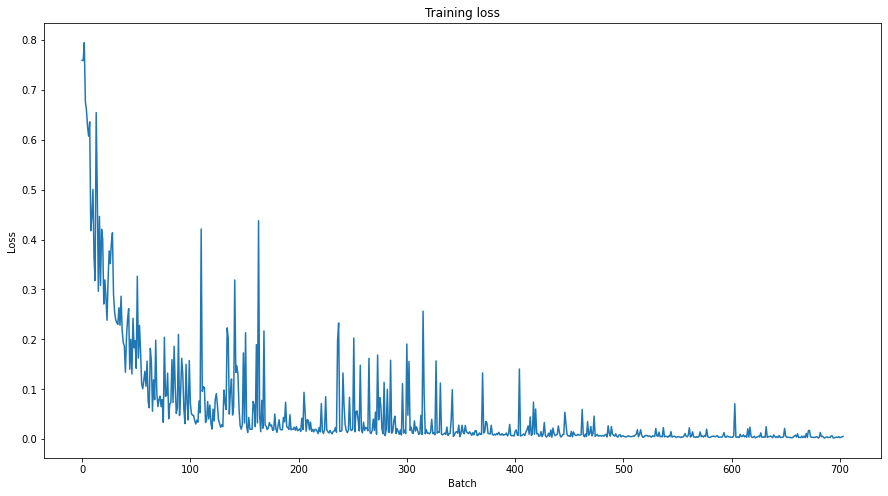

In [13]:
# BERT fine-tuning parameters
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2 * 1e-6,
                     warmup=.1)

# Function to calculate the accuracy of our predictions vs labels

  
# Store our loss and accuracy for plotting
train_loss_set = []
# Number of training epochs 
epochs = 4

# BERT training loop
for _ in trange(epochs, desc="Epoch"):  
  
  ## TRAINING
  
  # Set our model to training mode
  model.train()  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1
  print("Train loss: {}".format(tr_loss/nb_tr_steps))
       
  ## VALIDATION

  # Put model in evaluation mode
  model.eval()
  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0
  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1
  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

# plot training performance
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
model_save_name = 'classifier_300-500'
path = F"/content/gdrive/My Drive/175 BERT/{model_save_name}" 
torch.save(model.state_dict(), path)

In [ ]:
model_save_name = 'classifier.pt'
path = F"/content/gdrive/My Drive/175 BERT/{model_save_name}"
model.load_state_dict(torch.load(path))

In [ ]:
def print_correct_accuracy(mode = 0):
  i = 0
  wrong_set = set()
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0
  all_pro = []
  if mode == 0:
    current_dataloader = train_dataloader
  else:
    current_dataloader = validation_dataloader
  for batch in current_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    all_batches.append(logits)
    label_ids = b_labels.to('cpu').numpy()
    j = 0
    for pre, real in zip(logits, label_ids):
      all_pro.append(pre)
      if (real == 1 and pre[1] < pre[0]) or (real == 0 and pre[0] < pre[1]):
        wrong_set.add(i * 32 + j)
      
      j+=1
    
      
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1
    i+=1
  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
  return all_pro 

In [ ]:
import nltk
nltk.download('stopwords')
stops = set(stopwords.words("english"))
from sklearn.calibration import CalibratedClassifierCV
class BoWsvm:
    def __init__(self, train_file: str = "Constraint_English_Train.xlsx",
                 test_file: str = "Constraint_English_Val.xlsx"):
        # Extract basic Data
        self.X_train, self.Y_train = extract_data_from_file(train_file)
        X_train2, Y_train2 = extract_data_from_file(test_file)
        self.X_train, self.Y_train = self.X_train + X_train2, self.Y_train + Y_train2
        self.X_test, self.Y_test = extract_data_from_file("english_test_with_labels.xlsx")

        self.pipeline = Pipeline([
            ('bow', CountVectorizer()), #todo may try other paramethers here
            ('tfidf', TfidfTransformer()), #todo may use other transformer here
            ('classifier', CalibratedClassifierCV(base_estimator = LinearSVC()))
        ])
        self.pipeline.fit(self.X_train, self.Y_train)


    def test(self):
      return roc_auc_score(self.Y_test, self.pipeline.predict(self.X_test))
    def train_pos(self):
      return self.pipeline.predict_proba(self.X_train)
    def test_pos(self):
      return self.pipeline.predict_proba(self.X_test)
    def accuracy(self):
        output_list = self.pipeline.predict(self.X_test)
        matrix = np.zeros((2, 2))
        for c, v in zip(self.Y_train, output_list):
            if int(c) == 1:
                if v >= 0.5:
                    matrix[1, 1] += 1
                else:
                    matrix[1, 0] += 1
            else:
                if v <= 0.5:
                    matrix[0, 0] += 1
                else:
                    matrix[0, 1] += 1
        plot_matrix(matrix)
        return matrix

In [ ]:
def calculate_word_len():
    X_train1, Y_train1 = extract_data_from_file("Constraint_English_Train.xlsx")
    X_train2, Y_train2 = extract_data_from_file("Constraint_English_Val.xlsx")
    X_train, Y_train = X_train1 + X_train2, Y_train1 + Y_train2
    X_test, Y_test = extract_data_from_file("english_test_with_labels.xlsx")
    X_train_len = [len(sentence.split())/100 if len(sentence.split()) < 100 else 1.00 for sentence in X_train ]
    X_test_len = [len(sentence.split())/100 if len(sentence.split()) < 100 else 1.00 for sentence in X_test ]
    return X_train_len,X_test_len

In [ ]:
all_train_pro = print_correct_accuracy(0)
all_train_pro = [list(pro) for pro in all_train_pro]
fake_pro = [pro[0] for pro in all_train_pro]
real_pro = [pro[1] for pro in all_train_pro]

train_dict = {"BERT_fake_pro": fake_pro, "BERT_real_pro": real_pro}
a = BoWsvm()
all_pro = a.train_pos()
fake_pro = [pro[0] for pro in all_pro]
real_pro = [pro[1] for pro in all_pro]
train_dict["SVM_fake_pro"] = fake_pro
train_dict["SVM_real_pro"] = real_pro
train_dict["classification"] = a.Y_train


In [ ]:
all_test_pro = print_correct_accuracy(1)
all_test_pro = [list(pro) for pro in all_test_pro]
fake_pro = [pro[0] for pro in all_test_pro]
real_pro = [pro[1] for pro in all_test_pro]
test_dict = {"BERT_fake_pro": fake_pro, "BERT_real_pro": real_pro}
a = BoWsvm()
all_pro = a.test_pos()
fake_pro = [pro[0] for pro in all_pro]
real_pro = [pro[1] for pro in all_pro]
test_dict["SVM_fake_pro"] = fake_pro
test_dict["SVM_real_pro"] = real_pro
test_dict["classification"] = a.Y_test

In [ ]:
train_dict["len"] = calculate_word_len()[0]
test_dict["len"] = calculate_word_len()[1]

In [ ]:
from google.colab import drive
pd.DataFrame(train_dict).to_csv("/drive/My Drive/175 BERT/train_modified.csv", index = False)
pd.DataFrame(test_dict).to_csv("/drive/My Drive/175 BERT/test_modified.csv", index = False)
